In [1]:
%load_ext autoreload
%autoreload 2
import os


RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    # Move to default colab folder
    %cd /content
    # Check if repository is already cloned
    if not os.path.isdir("stg"):
        # Clone repository
        !git clone https://github.com/erik-buchholz/SoK-TrajGen.git stg
    # Change to repository directory
    %cd stg
    # Create output directory
    !mkdir -p img
    # SLOW: Only execute the following line if you encounter an error regarding a package not being installed
    # !pip install -r requirements.txt
else:
    import sys
    sys.path.append('..')  # Required for finding the `stg` module

In [2]:
import logging

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist

from stg.utils.logger import configure_root_loger
from stg import config

configure_root_loger(logging_level=logging.INFO)

<RootLogger root (INFO)>

In [3]:
# Configure matplotlib

column_width_pt = 241.14749  # pt 
page_width_pt = 506.295  # pt

def pt_to_cm(pt):
    return pt * 0.0352778

column_width = pt_to_cm(column_width_pt)
page_width = pt_to_cm(page_width_pt)
height = 2.5  # cm
print(f"Column width:\t{column_width:.2f} cm")
print(f"Page width:\t\t{page_width:.2f} cm")
print(f"Height:\t\t\t{height:.2f} cm")


plt.rcParams.update({
    'font.size': 8,  # Reduce size of tick-labels
    'axes.labelsize': 12,  # Increase axis labels font by 2
    'axes.titlesize': 13,  # Set title font size to same as axis labels
    'xtick.labelsize': 10,  # Tick-label font size
    'ytick.labelsize': 10,  # Tick-label font size
    'legend.fontsize': 12,  # Make the legend/label fonts a little smaller
    'figure.subplot.wspace': 0.1,  # Reduce space between subfigures
    'figure.subplot.hspace': 0.1,  # Reduce vertical space to 0.1
})

Column width:	8.51 cm
Page width:		17.86 cm
Height:			2.50 cm


In [4]:
# Load the data
data = np.load(config.BASE_DIR + "data/hd-issue.npz")
# Extract the data
cluster_A = data['cluster_A']
cluster_B = data['cluster_B']
cluster_A_plus = data['cluster_A_plus']
cluster_B_plus = data['cluster_B_plus']
centre_A = data['centre_A']
centre_B = data['centre_B']
hd = data['hd']
hd_plus = data['hd_plus']
a = data['a']
b = data['b']
a_plus = data['a_plus']
b_plus = data['b_plus']

In [5]:
generate_new = False

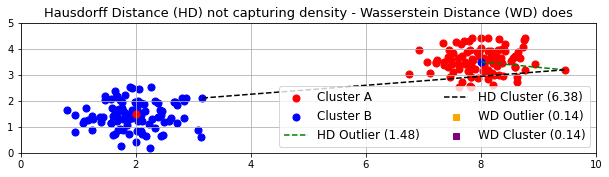

In [6]:
def hausdorff_distance(A, B):
    """
    Compute the Hausdorff distance between two sets of points.
    :return: HD, a, b where HD is the Hausdorff Distance, a is the point in A and b is the point in B
    in B that is furthest from A.
    """
    dists_A_to_B = cdist(A, B)
    h_A_to_B = np.max(np.min(dists_A_to_B, axis=1))
    h_B_to_A = np.max(np.min(dists_A_to_B, axis=0))
    
    if h_A_to_B > h_B_to_A:
        HD = h_A_to_B
        idx_A_to_B = np.argmax(np.min(dists_A_to_B, axis=1))
        a = A[idx_A_to_B]
        b = B[np.argmin(dists_A_to_B, axis=1)[idx_A_to_B]]
    else:
        HD = h_B_to_A
        idx_B_to_A = np.argmax(np.min(dists_A_to_B, axis=0))
        b = B[idx_B_to_A]
        a = A[np.argmin(dists_A_to_B, axis=0)[idx_B_to_A]]

    assert HD == np.linalg.norm(a - b)
    return HD, a, b

def two_dim_wasserstein_via_hist(a, b, bins=10):
    from scipy.stats import wasserstein_distance
    # Find support of the two distributions
    x_min = min(a[:, 0].min(), b[:, 0].min())
    x_max = max(a[:, 0].max(), b[:, 0].max())
    y_min = min(a[:, 1].min(), b[:, 1].min())
    y_max = max(a[:, 1].max(), b[:, 1].max())
    hist_a, _ = np.histogramdd(a, bins=bins, range=[[x_min, x_max], [y_min, y_max]])
    hist_b, _ = np.histogramdd(b, bins=bins, range=[[x_min, x_max], [y_min, y_max]])
    return wasserstein_distance(hist_a.flatten(), hist_b.flatten())

if generate_new:
    # Create two central points for the clusters with [0, 0] to [10, 5]
    centre_A = np.array([2, 1.5])
    centre_B = np.array([8, 3.5])
    
    # Generating new clusters such that they fit within the y-axis boundaries of 0 and 5
    factor = 0.5
    cluster_A = np.random.randn(100, 2) * factor + centre_A
    cluster_B = np.random.randn(100, 2) * factor + centre_B
    
    # Inserting the central point from Cluster B into Cluster A and vice versa
    cluster_A_plus = np.vstack([cluster_A, centre_B])
    cluster_B_plus = np.vstack([cluster_B,centre_A])

# Compute the HD between cluster A and B
hd, a, b = hausdorff_distance(cluster_A, cluster_B)

# Compute the HD between cluster A+ and B+
hd_plus, a_plus, b_plus = hausdorff_distance(cluster_A_plus, cluster_B_plus)

# Plotting the new clusters with the Hausdorff distance highlighted
plt.figure(figsize=(column_width, height))
plt.scatter(cluster_B[:, 0], cluster_B[:, 1], color='red', label='Cluster A', s=50)
plt.scatter(cluster_A[:, 0], cluster_A[:, 1], color='blue', label='Cluster B', s=50)
# Plot the additional points over the original clusters
plt.scatter(centre_A[0], centre_A[1], color='red', s=50)
plt.scatter(centre_B[0], centre_B[1], color='blue', s=50)
plt.plot([a_plus[0], b_plus[0]], [a_plus[1], b_plus[1]], color='green', linestyle='--', label=f'HD Outlier ({hd_plus:.2f})')
plt.plot([a[0], b[0]], [a[1], b[1]], color='black', linestyle='--', label=f'HD Cluster ({hd:.2f})')
plt.title("Hausdorff Distance (HD) not capturing density - Wasserstein Distance (WD) does")
plt.ylim(0, 5)  # Setting y-axis limits
plt.xlim(0, 10)  # Setting x-axis limits

# Use ticks on full numbers without labels
# plt.xticks(np.arange(0, 11, 1), [])
# plt.yticks(np.arange(0, 6, 1), [])

# Add 2d Wasserstein distance to legend
wd_1 = two_dim_wasserstein_via_hist(cluster_A, cluster_B)
wd_2 = two_dim_wasserstein_via_hist(cluster_A_plus, cluster_B_plus)
plt.scatter([], [], color='orange', marker='s', label=f'WD Outlier ({wd_1:.2f})')
plt.scatter([], [], color='purple', marker='s', label=f'WD Cluster ({wd_2:.2f})')
# Legend with 2 columns
plt.legend(loc='lower right', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig(config.BASE_DIR + "img/hd-issue.png", dpi=300)
plt.show()

# for bins in range(5, 50, 5): 
#     print(f"Bins:\t{bins}")
#     wd = two_dim_wasserstein_via_hist(cluster_A, cluster_B, bins=bins)
#     print(f"Wasserstein Distance:\t{wd:.2f}")
#     wd_plus = two_dim_wasserstein_via_hist(cluster_A_plus, cluster_B_plus, bins=bins)
#     print(f"Wasserstein Distance+:\t{wd_plus:.2f}")

In [7]:
# Store the data
np.savez(config.BASE_DIR + "data/hd-issue.npz", 
         cluster_A=cluster_A, cluster_B=cluster_B, 
         cluster_A_plus=cluster_A_plus, cluster_B_plus=cluster_B_plus,
         centre_A=centre_A, centre_B=centre_B,
         hd=hd, hd_plus=hd_plus,
         a=a, b=b, a_plus=a_plus, b_plus=b_plus)